## Capstone 2: Music Recommender App 
### LightFM Model (Interaction based hybrid model)


In [1]:
##### !pip install lightfm

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse as sp
from matplotlib import pyplot as plt

from lightfm import LightFM
from sklearn.metrics import pairwise as pw
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank

sns.set()
warnings.filterwarnings('ignore')

%matplotlib inline

d:\ProgramData\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Useful functions for detailed data inspection

In [3]:
# Create Data audit Report for continuous variables
def cont_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [4]:
# Create Data audit Report for categorical variables
def cat_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [5]:
# Function to return key for any value
def get_key(val, dictionary):
    for key, value in dictionary.items():
         if val == value:
                return key
 
    raise Exception("Song doesn't exist in the database")

## popularity based model

In [6]:
# Class for Popularity based Recommender System model
class popularity_recommender():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    # Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        # Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        # Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        # Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        # Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    # Use the popularity based recommender system model to make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        # Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        # Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations

## Useful functions for personalized hybrid recommendation model

In [7]:
# Function to create a user dictionary based on their index and number in interaction dataset
def create_user_dict(interactions):
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 

    for i in user_id:
        user_dict[i] = counter
        counter += 1

    new_dict = dict([(value, key) for key, value in user_dict.items()])

    return new_dict

In [8]:
# Function to create an item dictionary based on their item_id and item name  
def create_item_dict(df, id_col, name_col):
    item_dict ={}

    for i in range(df.shape[0]):
        item_dict[(df.loc[i, id_col])] = df.loc[i, name_col]

    return item_dict

In [50]:
# Function to produce user recommendations
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict, threshold = 0, nrec_items = 10):
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x, np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id, :] \
                                 [interactions.loc[user_id, :] > threshold].index) \
								   .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0: nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    
    print("Recommended songs for UserID:", user_id)
    counter = 1

    for i in scores:
        print(str(counter) + '- ' + i)
        counter+=1

In [10]:
# Function to create item-item distance embedding matrix
def create_item_emdedding_distance_matrix(model, interactions):
    
    df_item_norm_sparse = sp.csr_matrix(model.item_embeddings)
    similarities = pw.cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = interactions.columns
    item_emdedding_distance_matrix.index = interactions.columns
    
    return item_emdedding_distance_matrix

In [11]:
# Function to create item-item recommendation
def item_item_recommendation(item_emdedding_distance_matrix, item_id, item_dict, n_items = 10):
    
    recommended_items = list(pd.Series(item_emdedding_distance_matrix.loc[item_id,:]. \
                                  sort_values(ascending = False).head(n_items+1). \
                                  index[1:n_items+1]))
    
    print("Song of interest: {0}".format(item_dict[item_id]))
    print("Song(s) similar to the above item are as follows:-")
    counter = 1
    
    for i in recommended_items:
        print(str(counter) + '. ' +  item_dict[i])
        counter+=1

## Data Import & Inspection

In [12]:
triplets = 'https://static.turi.com/datasets/millionsong/10000.txt'
songsData = 'https://static.turi.com/datasets/millionsong/song_data.csv'

In [13]:
rawData1 = pd.read_table(triplets, header=None)
rawData1.columns = ['user_id', 'song_id', 'listen_count']
rawData2 =  pd.read_csv(songsData)

In [14]:
# Create a new copy of the triplets dataset & change user_ids
# from string format to indexed values for easier computations
rawData1_userIndexed = rawData1.copy()
rawData1_userIndexed.user_id = rawData1.index + 1

In [15]:
# Merge the triplets data (user indexed) with songs data
rawData = pd.merge(rawData1_userIndexed, rawData2.drop_duplicates(['song_id']), on="song_id", how="left")

In [16]:
# Create a subset of top fifty thousand observations to work with, 
# as the entire dataset is TOO expensive to compute on!!!
data = rawData.head(50000).copy()

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       50000 non-null  int64 
 1   song_id       50000 non-null  object
 2   listen_count  50000 non-null  int64 
 3   title         50000 non-null  object
 4   release       50000 non-null  object
 5   artist_name   50000 non-null  object
 6   year          50000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 3.1+ MB


In [18]:
data.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,1,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,2,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,3,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,4,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,5,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [19]:
data.tail()

,user_id,song_id,listen_count,title,release,artist_name,year
49995,49996,SOBRFPG12A8AE4837D,1,El Novio Del Olvido,Alta Suciedad,Andres Calamaro,1997
49996,49997,SOBSIFR12A6D4F8560,1,Geek In The Pink [Phil Tan Remix],Geekin' Out Across The Galaxy,Jason Mraz,2006
49997,49998,SOBVTVL12A8C1422D7,2,Yo Tomo,Libertinaje,Bersuit Vergarabat,1998
49998,49999,SOBXOWJ12A6D4F85BA,1,Wordplay (Album Version),Mr. A-Z,Jason Mraz,2005
49999,50000,SOCGYWW12A8C13BB00,1,I'll Do Anything (LP Version),Waiting For My Rocket To Come,Jason Mraz,2002


In [20]:
data.describe(include='all')

,user_id,song_id,listen_count,title,release,artist_name,year
count,50000.000000,50000,50000.00000,50000,50000,50000,50000.000000
unique,NaN,9370,NaN,8976,5108,3215,NaN
top,NaN,SOFRQTD12A81C233C0,NaN,Sehr kosmisch,Greatest Hits,Coldplay,NaN
freq,NaN,204,NaN,204,354,751,NaN
mean,25000.500000,NaN,3.02526,NaN,NaN,NaN,1635.559200
std,14433.901067,NaN,7.16088,NaN,NaN,NaN,773.351054
min,1.000000,NaN,1.00000,NaN,NaN,NaN,0.000000
25%,12500.750000,NaN,1.00000,NaN,NaN,NaN,1985.000000
50%,25000.500000,NaN,1.00000,NaN,NaN,NaN,2003.000000
75%,37500.250000,NaN,3.00000,NaN,NaN,NaN,2007.000000


In [21]:
data.select_dtypes(include='int64').apply(cont_summary)

,user_id,listen_count,year
N,5.000000e+04,50000.000000,5.000000e+04
NMISS,0.000000e+00,0.000000,0.000000e+00
SUM,1.250025e+09,151263.000000,8.177796e+07
MEAN,2.500050e+04,3.025260,1.635559e+03
MEDIAN,2.500050e+04,1.000000,2.003000e+03
STD,1.443390e+04,7.160880,7.733511e+02
VAR,2.083375e+08,51.278207,5.980719e+05
MIN,1.000000e+00,1.000000,0.000000e+00
P1,5.009900e+02,1.000000,0.000000e+00
P5,2.500950e+03,1.000000,0.000000e+00


In [22]:
data.select_dtypes(include='object').apply(cat_summary)

,song_id,title,release,artist_name
N,50000,50000,50000,50000
NMISS,0,0,0,0
MODE,SOFRQTD12A81C233C0,Sehr kosmisch,Greatest Hits,Coldplay
FREQ,204,204,354,751
PERCENT,0.41,0.41,0.71,1.5


## EDA

In [23]:
grp_title = rawData.groupby(['title']).agg({'listen_count': 'count'}).reset_index()
grp_title['percentage'] = rawData['listen_count'].div(rawData.listen_count.sum()) * 100
grp_title

,title,listen_count,percentage
0,#!*@ You Tonight [Featuring R. Kelly] (Explici...,78,0.000016
1,#40,338,0.000033
2,& Down,373,0.000016
3,' Cello Song,103,0.000016
4,'97 Bonnie & Clyde,93,0.000016
...,...,...,...
9562,the Love Song,70,0.000016
9563,you were there with me,79,0.000082
9564,¡Viva La Gloria! (Album Version),171,0.000016
9565,¿Lo Ves? [Piano Y Voz],71,0.000016


In [24]:
grp_title.sort_values(by=['listen_count']).head(10)

,title,listen_count,percentage
2860,Ghosts (Toxic Avenger Mix),48,0.000016
5567,No Creo En El Jamas,48,0.000049
2041,Don´t Leave Me Now,50,0.000016
3363,Historia Del Portero,51,0.000016
6782,Scared,51,0.000148
8309,The Worm,52,0.000033
57,2nd Self,52,0.000016
842,Big Girls Don't Cry,52,0.000049
12,(I Can't Get Me No) Satisfaction,52,0.000016
2162,Déjame llorar,52,0.000016


In [25]:
grp_title.sort_values(by=['listen_count'], ascending=False).head(10)

,title,listen_count,percentage
6836,Sehr kosmisch,8277,0.000033
8725,Undo,7032,0.000066
1964,Dog Days Are Over (Radio Edit),6949,0.000016
9496,You're The One,6729,0.000016
6498,Revelry,6145,0.000016
6825,Secrets,5841,0.000016
3437,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385,0.000016
2595,Fireflies,4795,0.000033
3322,Hey_ Soul Sister,4758,0.000049
8494,Tive Sim,4548,0.000033


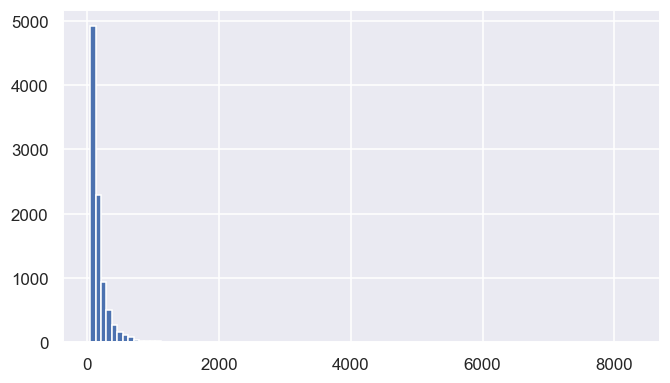

In [26]:
plt.figure(figsize=(7, 4), dpi=110)
plt.hist(grp_title.listen_count, bins=100)
plt.show()

## Recommedations

In [27]:
users = data['user_id'].unique()

## Interaction Matrix

In [28]:
# Create a pivot table (interaction matrix) from the original dataset
x = data.pivot_table(index='user_id', columns='song_id', values='listen_count')

In [29]:
xNan = x.fillna(0)

In [30]:
interaction = sp.csr_matrix(xNan.values)

## Popularity Model

In [32]:
id = int(input('Enter the ID of a user to get their popularity-based song recommendations: '))

Enter the ID of a user to get their popularity-based song recommendations: 49996


In [33]:
popModel = popularity_recommender()

In [34]:
# Popularity based recommendations by title
popModel.create(data, 'user_id', 'title')
popModel.recommend(users[id-1])

,user_id,title,score,Rank
6421,49996,Sehr kosmisch,204,1.0
8186,49996,Undo,182,2.0
8909,49996,You're The One,181,3.0
1846,49996,Dog Days Are Over (Radio Edit),173,4.0
6100,49996,Revelry,166,5.0
6410,49996,Secrets,158,6.0
3214,49996,Horn Concerto No. 4 in E flat K495: II. Romanc...,134,7.0
2427,49996,Fireflies,128,8.0
7968,49996,Tive Sim,117,9.0
3109,49996,Hey_ Soul Sister,109,10.0


In [35]:
# Popularity based recommendations by artists
popModel.create(data, 'user_id', 'artist_name')
popModel.recommend(users[id-1])

,user_id,artist_name,score,Rank
623,49996,Coldplay,751,1.0
2717,49996,The Black Keys,644,2.0
1586,49996,Kings Of Leon,517,3.0
1065,49996,Florence + The Machine,461,4.0
1318,49996,Jack Johnson,412,5.0
2804,49996,The Killers,407,6.0
2273,49996,Radiohead,396,7.0
707,49996,Daft Punk,394,8.0
942,49996,Eminem,382,9.0
1490,49996,Justin Bieber,342,10.0


## Personalized Hybrid Model

In [36]:
hybridModel = LightFM(loss='warp-kos', n=20, k=20, learning_schedule='adadelta')
hybridModel.fit(interaction, epochs=600, num_threads=512)

In [37]:
precision_at_k(hybridModel, interaction).mean().round(4) * 100

10.000000149011612

In [38]:
recall_at_k(hybridModel, interaction).mean().round(4) * 100

100.0

In [39]:
auc_score(hybridModel, interaction).mean().round(4) * 100

100.0

In [40]:
reciprocal_rank(hybridModel, interaction).mean().round(4) * 100

97.93000221252441

## Personal Recommendations

In [41]:
# Creating user dictionary based on their index and number in the interaction matrix using recsys library
userDict = create_user_dict(interactions=x)

In [42]:
# Creating a song dictionary based on their songID and artist name
songDict = create_item_dict(df=rawData, id_col='song_id', name_col='title')

In [43]:
# Recommend songs using lightfm library
id = int(input('Enter the ID of a user to get their personalized song recommendations: '))
sample_recommendation_user(model=hybridModel, interactions=x, user_id=id, 
                           user_dict=userDict, item_dict=songDict, threshold=5, nrec_items=10)

Enter the ID of a user to get their personalized song recommendations: 49996
Recommended songs for UserID: 49996
1- Yo Tomo
2- Sexy Bitch
3- Mr Sandman
4- Jackie_ Dressed In Cobras
5- Hey Sexy Lady
6- Superman
7- Imma Be
8- Black Door
9- Whataya Want From Me
10- Damaged Goods


In [ ]:
# Recommend songs similar to a given songID
song = input('Enter a song to get similar recommendations: ')
songID = get_key(song, songDict)
songItemDist = create_item_emdedding_distance_matrix(model=hybridModel, interactions=x)
item_item_recommendation(item_emdedding_distance_matrix=songItemDist, item_id=songID,
                                    item_dict=songDict, n_items=10)

In [47]:
songDict

{'SOAKIMP12A8C130995': 'The Cove',
 'SOBBMDR12A8C13253B': 'Entre Dos Aguas',
 'SOBXHDL12A81C204C0': 'Stronger',
 'SOBYHAJ12A6701BF1D': 'Constellations',
 'SODACBL12A8C13C273': 'Learn To Fly',
 'SODDNQT12A6D4F5F7E': "Apuesta Por El Rock 'N' Roll",
 'SODXRTY12AB0180F3B': 'Paper Gangsta',
 'SOFGUAY12AB017B0A8': 'Stacked Actors',
 'SOFRQTD12A81C233C0': 'Sehr kosmisch',
 'SOHQWYZ12A6D4FA701': "Heaven's gonna burn your eyes",
 'SOIYTOA12A6D4F9A23': 'Let It Be Sung',
 'SOIZAZL12A6701C53B': "I'll Be Missing You (Featuring Faith Evans & 112)(Album Version)",
 'SOJNNUA12A8AE48C7A': 'Love Shack',
 'SOJPFQG12A58A7833A': 'Clarity',
 'SOKRIMP12A6D4F5DA3': "I?'m A Steady Rollin? Man",
 'SOLLGNU12AF72A4D4F': 'The Old Saloon',
 'SOMGIYR12AB0187973': 'Behind The Sea [Live In Chicago]',
 'SOMLMKI12A81C204BC': 'Champion',
 'SOMSQJY12A8C138539': 'Breakout',
 'SONSAEZ12A8C138D7A': 'Ragged Wood',
 'SOOKGRB12A8C13CD66': 'Mykonos',
 'SOPCVQE12AC468AF36': 'Country Road',
 'SOQIVUD12AB01821D2': 'Oh No',
 'SOQJLD